Single plot 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import ListedColormap
from decimal import Decimal, ROUND_HALF_UP


def plot_protocol_with_loss(save_path, combined_simulation_data, combined_loss_data, terminal_soc=0.9, type='nn',custom_colors=None):
    """
    Plot four subplots (current, voltage, SoC, temperature) with colors assigned to each case 
    based on loss values (from dark blue to light blue).
    Use inset_axes to create a small colorbar showing sorted SoH values (derived from loss).
    """
    # 1. Sort by loss value: lower loss comes first (better performance)
    sorted_cases = sorted(combined_loss_data, key=combined_loss_data.get)  # e.g.: ['case1_Best', 'case2_Best', 'case1_Middle', ...]
    n = len(sorted_cases)

    base_colors = ["#0747a1", "#cce6ff"]  
    cmap = LinearSegmentedColormap.from_list("custom_blue", base_colors, N=n)

    # 2. If custom_colors is not provided, generate using default logic
    if custom_colors is None:

        # Assign colors
        colors = {}
        for i, case in enumerate(sorted_cases):
            if i == 0:
                colors[case] = "#043178"  # Darker color for first place
            else:
                colors[case] = mcolors.to_hex(cmap(i / (n - 1)))

    else:
        colors = custom_colors

    
    color_list = [colors[case] for case in sorted_cases]
    
    # 4. Create 4 subplots (current, voltage, SoC, temperature)
    fig, axes = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(6, 10))
    ax_current, ax_voltage, ax_soc, ax_temp = axes

    # 5. Add reference lines
    ax_current.axhline(0, linestyle="--", linewidth=1, color="gray")
    ax_voltage.axhline(4.2, linestyle="--", linewidth=1, color="gray")
    ax_voltage.axhline(3.0, linestyle="--", linewidth=1, color="gray")
    ax_soc.axhline(terminal_soc, linestyle="--", linewidth=1, color="gray")
    ax_soc.axhline(0.0, linestyle="--", linewidth=1, color="gray")
    ax_temp.axhline(298.15, linestyle="--", linewidth=1, color="gray")  # Room temperature reference (25°C)
    
    # 6. Assume all cases share the same time interval (sample from any case)
    sample_case = list(combined_simulation_data.values())[-1]

    # Determine if temperature data is included based on data length
    if len(sample_case) == 4:
        t_common, I_common = sample_case[0], sample_case[1]
    else:
        t_common, I_common = sample_case[0], sample_case[1]
    
    t_common_in_hours = t_common / 3600

    # 7. Determine charging/discharging regions (example: current < -0.01 for charging)
    charge_regions = I_common < -0.01
    def find_regions(condition):
        regions = []
        start = None
        for i, cond in enumerate(condition):
            if cond and start is None:
                start = i
            elif not cond and start is not None:
                regions.append((t_common[start], t_common[i-1]))
                start = None
        if start is not None:
            regions.append((t_common[start], t_common[-1]))
        return regions

    charging_intervals = find_regions(charge_regions)
    discharging_intervals = find_regions(~charge_regions)
    charging_intervals_in_hours = [(start/3600, end/3600) for (start, end) in charging_intervals]
    discharging_intervals_in_hours = [(start/3600, end/3600) for (start, end) in discharging_intervals]

    # 8. Add shaded regions to all subplots
    for interval in charging_intervals_in_hours:
        for ax in axes:
            ax.axvspan(*interval, color="#eddca5", alpha=0.3)
    for interval in discharging_intervals_in_hours:
        for ax in axes:
            ax.axvspan(*interval, color="lightgray", alpha=0.3)

    # 9. Plot curves for each case using assigned colors
    for case, data in combined_simulation_data.items():
        # Compatible with both 4-element data (t, I, V, soc) and 5-element data (t, I, V, soc, T)
        if len(data) == 4:
            t, I, V, soc = data
            T = None  # No temperature curve if temperature data is missing
        else:
            t, I, V, soc, T = data  # data should be (t, I, V, soc, T)
            
        t_in_hours = t / 3600
        color = colors.get(case, "black")
        ax_current.plot(t_in_hours, I, linestyle="-", color=color, 
                        label=f"{case} (loss: {combined_loss_data[case]:.2f})", alpha=0.8)
        ax_voltage.plot(t_in_hours, V, linestyle="-", color=color, alpha=0.9)
        ax_soc.plot(t_in_hours, soc, linestyle="-", color=color, alpha=0.8)
        
        # Plot temperature curve if temperature data exists
        if T is not None:
            ax_temp.plot(t_in_hours, T, linestyle="-", color=color, alpha=0.8)

    # 10. Add auxiliary text for each subplot
    ax_current.text(0.72, 0.82, 'Charging', transform=ax_current.transAxes, fontsize=11, color='gray', alpha=0.6)
    ax_current.text(0.22, 0.82, 'Discharging', transform=ax_current.transAxes, fontsize=11, color='gray', alpha=0.6)
    ax_voltage.text(t_common_in_hours[-1]*0.78, 4.18, '4.2V', va='top', ha='right', fontsize=10, color='gray')
    ax_voltage.text(t_common_in_hours[-1]*0.95, 3.0, '3.0V', va='bottom', ha='right', fontsize=10, color='gray')
    ax_soc.text(t_common_in_hours[-1]*0.93-0.2, terminal_soc-0.03, f'{terminal_soc*100:.0f}% SoC', va='top', ha='right', fontsize=10, color='gray')
    ax_soc.text(t_common_in_hours[-1]*0.95, 0, '0% SoC', va='bottom', ha='right', fontsize=10, color='gray')
    ax_temp.text(t_common_in_hours[-1]*0.91, 298.15+2.5, '25°C', va='top', ha='right', fontsize=10, color='gray')

    # 11. Add示意arrows (adjust as needed)
    if charging_intervals_in_hours:
        ax_current.annotate(
            '', 
            xy=(charging_intervals_in_hours[0][0], 1.3), 
            xytext=(charging_intervals_in_hours[0][1], 1.3),
            arrowprops=dict(arrowstyle='<->', color='black')
        )
        ax_current.text(
            (charging_intervals_in_hours[0][0] + charging_intervals_in_hours[0][1]) / 2, 1.35, 
            f'0.5h 0-{terminal_soc*100:.0f}% SoC', 
            ha='center', va='bottom', fontsize=8, color='black'
        )

    # 12. Set title and axis labels
    if type == 'nn':
        fig.suptitle("Battery Protocols Optimized by Neural Network Based on SOH", fontsize=11, fontweight='bold', ha='center')
    elif type == 'control':
        fig.suptitle("Battery Protocols Optimized by Control Algorithm Based on SOH", fontsize=11, fontweight='bold', ha='center')
    else:
        fig.suptitle("Multi-Step CCCV Battery Protocols Based on SOH", fontsize=11, fontweight='bold', ha='center')
    ax_current.set_ylabel("Current [A]")
    ax_voltage.set_ylabel("Voltage [V]")
    ax_soc.set_ylabel("SoC")
    ax_temp.set_ylabel("Temperature [K]")
    ax_temp.set_xlabel("Time [h]")
    
    # 13. Create a small inset colorbar to represent SoH (derived from loss) from dark to light
    norm = mpl.colors.Normalize(vmin=0, vmax=1)
    sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    # Create a small colorbar area in the lower left corner of ax_current
    cax = inset_axes(ax_current, width="38%", height="3%", loc='lower left', borderpad=5)
    cbar = plt.colorbar(sm, cax=cax, orientation='horizontal')
    
    # Calculate actual SoH values for colorbar ticks
    # Formula: SoH = 0.93 + 0.07 * exp(-loss)
    cmap_discrete = ListedColormap(color_list)

    # 4) Create ScalarMappable using this discrete colormap for colorbar
    norm = mpl.colors.Normalize(vmin=0, vmax=n - 1)  # or 0~1, depending on scale preference
    sm = mpl.cm.ScalarMappable(cmap=cmap_discrete, norm=norm)
    sm.set_array([])

    # 5) Draw colorbar
    cbar = plt.colorbar(sm, cax=cax, orientation='horizontal')
    cbar.set_ticks(range(n))  # Discrete ticks
    # Assuming you want to map SoH values to each case
    soh_values_sorted = [0.6 + 0.4 * np.exp(-combined_loss_data[case]) for case in sorted_cases]
    # soh_loss = (1 - np.array(soh_values_sorted))*100
    soh_loss = np.array(soh_values_sorted)*100

    def format_half_up(value, ndigits=2):
        """
        Perform traditional rounding (ROUND_HALF_UP) on value, keeping ndigits decimal places,
        return as string without unnecessary trailing zeros (always keep ndigits decimal places).
        """
        # Construct quantization like 0.01, 0.001, etc.
        quantize_str = '0.' + '0'*(ndigits-1) + '1'
        d = Decimal(str(value)).quantize(Decimal(quantize_str), rounding=ROUND_HALF_UP)
        return f"{d:.{ndigits}f}"
    
    labels = [ format_half_up(soh_val, 2) for soh_val in soh_loss ]

    cbar.set_ticklabels(labels)
    cbar.set_label("SoH %", fontsize=10)
    cbar.ax.tick_params(labelsize=10)
    
    # 14. Adjust layout, save and show image
    fig.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.show()
    plt.close(fig)


Running function

In [ ]:
import os
import sys
sys.path.append(os.path.abspath(".."))

import pybamm
import numpy as np
import matplotlib.pyplot as plt
import logging
import torch
import csv
import torch.nn as nn
import importlib.util
from pathlib import Path
from typing import Callable, Dict
import pandas as pd
import random
from show_searching_space import *  # Custom utility functions
# from .. import show_searching_space
from ac_simulation_RNN import BatteryCyclingExperiment
from cccv_simulation_multi import BatteryCyclingExperiment_CCCV
from control_llm.control_simulation_full_cycle import BatteryCyclingExperiment as BatteryCyclingExperiment_control


p=13
class BatteryExperimentRunner:
    def __init__(self, input_folder, terminal_soc=0.9, num_cycles=2, num_cc=3, type_name='nn'):
        """
        Initializes the runner with an input folder that contains:
        - A model_architecture.py file defining 'NeuralNetwork'.
        - A single 'all_params.pth' with stored parameters.
        """
        self.input_folder = input_folder
        self.terminal_soc = terminal_soc
        self.type_name = type_name
        self.num_cc = num_cc
        self.num_cycles = num_cycles
        self.h_prev = None
        # self.model = self.load_model()
        self.csv_rows = self.load_csv() 

    def load_model(self):
        """
        Dynamically loads the model architecture from a Python file.
        """
        model_path = os.path.join(self.input_folder, "model_architecture.py")
        spec = importlib.util.spec_from_file_location("model_architecture", model_path)
        module = importlib.util.module_from_spec(spec)
        spec.loader.exec_module(module)
        self.module = module
        return module.NeuralNetwork()

    def load_nn_in_pybamm(self):
        """
        Dynamically loads the model architecture from a Python file.
        """
        model_path = os.path.join(self.input_folder, "model_architecture.py")
        spec = importlib.util.spec_from_file_location("model_architecture", model_path)
        module = importlib.util.module_from_spec(spec)
        spec.loader.exec_module(module)
        self.module = module
        return module.nn_in_pybamm
    
    def load_csv(self):
        """
        Loads the CSV so we can determine best, worst, and median based on 'total_loss'.
        Assumes each row corresponds to a single parameter set, in the same order as 'all_params.pth'.
        For control experiments, uses 'generation_log.csv', otherwise uses 'optimization_results.csv'.
        """
        if self.type_name == 'control':
            csv_filename = "generation_log.csv"
        else:
            csv_filename = "optimization_results.csv"
            
        csv_path = os.path.join(self.input_folder, csv_filename)
        if not os.path.exists(csv_path):
            raise FileNotFoundError(f"'{csv_path}' not found. Make sure it exists.")
        rows = []
        with open(csv_path, 'r') as f:
            reader = csv.DictReader(f)
            for row in reader:
                rows.append(row)
        return rows

    def apply_parameters(self, param_index):
        self.model = self.load_model()
        """
        Loads parameters from 'all_params.pth' by index and applies them to the model.
        'param_index' indicates which saved parameter set to use.
        """
        pth_file = os.path.join(self.input_folder, 'all_params.pth')
        if not os.path.exists(pth_file):
            raise FileNotFoundError(f"'{pth_file}' not found. Make sure it exists and contains parameter data.")

        stored_params = torch.load(pth_file)
        if param_index < 0 or param_index >= len(stored_params):
            raise IndexError(f"Parameter index {param_index} is out of range in 'all_params.pth'.")

        param_data = stored_params[param_index]

        # If 'param_data' is a dict (e.g., {'fc1.weight_0': val, ...}), apply accordingly.
        if isinstance(param_data, dict):
            grouped_data = {}
            for k, v in param_data.items():
                if "_" in k:
                    base, idx = k.rsplit("_", 1)
                    if idx.isdigit():
                        grouped_data.setdefault(base, []).append((int(idx), v))
                    else:
                        grouped_data.setdefault(k, []).append((0, v))
                else:
                    grouped_data.setdefault(k, []).append((0, v))

            for name, param in self.model.named_parameters():
                pairs = grouped_data[name]
                pairs.sort(key=lambda x: x[0])
                values = [p[1] for p in pairs]
                param_tensor = torch.tensor(
                    values,
                    dtype=torch.float32,
                    device=next(self.model.parameters()).device
                ).reshape(param.shape)
                param.data.copy_(param_tensor)
        else:
            # If 'param_data' is a list of floats, apply them in order.
            idx = 0
            param_dict = {}
            for name, param in self.model.named_parameters():
                num_params = param.numel()
                param_tensor = torch.tensor(
                    param_data[idx:idx + num_params],
                    dtype=torch.float32,
                    device=next(self.model.parameters()).device
                ).reshape(param.shape)
                param_dict[name] = param_tensor
                idx += num_params
            for name, param in self.model.named_parameters():
                param.data.copy_(param_dict[name])

    def apply_parameters_cccv(self, param_index):
        """
        Loads parameters from 'all_params.pth' by index and returns a list
        [cc1, cc2, …, ccN] of length self.num_cc.
        If stored as dict, expects keys 'cc1'..'cc{num_cc}'.  
        If stored as list/tuple, expects at least self.num_cc entries.
        Empty strings are replaced with 0.0.
        """
        import os, torch

        pth_file = os.path.join(self.input_folder, 'all_params.pth')
        if not os.path.exists(pth_file):
            raise FileNotFoundError(f"{pth_file!r} not found.")

        stored = torch.load(pth_file)
        if param_index < 0 or param_index >= len(stored):
            raise IndexError(f"Index {param_index} out of range.")

        raw = stored[param_index]
        def parse(x):
            if isinstance(x, str) and x.strip()=="":
                return 0.0
            return float(x)

        # dict case
        if isinstance(raw, dict):
            # verify keys
            missing = [i for i in range(1, self.num_cc+1)
                       if f"cc{i}" not in raw]
            if missing:
                raise KeyError(f"Missing keys: {['cc'+str(i) for i in missing]}")
            cc_rates = [parse(raw[f"cc{i}"]) for i in range(1, self.num_cc+1)]

        # list/tuple case
        elif isinstance(raw, (list, tuple)) and len(raw) >= self.num_cc:
            cc_rates = [parse(raw[i-1]) for i in range(1, self.num_cc+1)]

        else:
            raise ValueError(
                "Stored params must be dict with cc1..ccN or list/tuple of length ≥ N."
            )

        print(f"Loaded cc_rates (len={len(cc_rates)}): {cc_rates}")
        return cc_rates

    def run_experiment_cccv(self, param_index, case_name,
                            t_start=0, t_end=7200, num_points=1000):
        """
        Runs a CCCV experiment using the parameter set at 'param_index'
        (now a list of length self.num_cc) and saves plots/results.
        """
        # get a list [cc1, …, ccN]
        cc_rates = self.apply_parameters_cccv(param_index)

        # pass the entire list into your experiment
        experiment = BatteryCyclingExperiment_CCCV(
            num_cycles=self.num_cycles,
            SOC=self.terminal_soc,
            cc_rates=cc_rates,
            charging_duration=0.5,
        )
        final_solution, soh_values = experiment.run_cycles()

        # 保存输出结果
        output_folder = os.path.join(self.input_folder, "output", case_name)
        experiment.plot_results(final_solution, soh_values, save_path=output_folder)
        return final_solution, soh_values

    def get_fc_weights(self, model: nn.Module):	
        """Return (Ws, bs) lists for *all* nn.Linear layers in *forward order*.

        The order is determined by a forward trace via ``torch.fx``, ensuring that
        even with branches / loops the weights align with actual execution.
        """
        import torch.fx as fx

        # dummy = torch.randn(1, 3)  # shape matches network input (V, T, SoC)
        gm = fx.symbolic_trace(model)

        Ws, bs = [], []
        lin_modules = dict(model.named_modules())
        for node in gm.graph.nodes:
            if node.op == "call_module":
                mod = lin_modules[node.target]
                if isinstance(mod, nn.Linear):
                    Ws.append(mod.weight.detach().cpu().numpy())
                    if mod.bias is not None:  
                        bs.append(mod.bias.detach().cpu().numpy())
        return Ws, bs
    
    def is_rnn_model(self):
        """
        检测模型是否为RNN类型
        Returns:
            bool: True if RNN (4 parameters), False if MLP (3 parameters)
        """
        import inspect
        nn_func_params = inspect.signature(self.nn_in_pybamm).parameters
        return len(nn_func_params) == 4

    @staticmethod
    def adaptive_current_core(vars_dict, self_ref, Ws, bs):
        V   = vars_dict["Voltage [V]"]
        T   = vars_dict["Volume-averaged cell temperature [K]"]
        soc = vars_dict["SoC"]

        Vn = 2 * ((V - 3.0) / (4.2 - 3.0)) - 1
        Tn = 2 * ((T - 308.15) / (p)) - 1
        Sn = 2 * (soc - 0.5)

        X = [pybamm.Scalar(10) * Vn,
            pybamm.Scalar(10) * Tn,
            pybamm.Scalar(10) * Sn]

        # 自动检测模型类型并调用相应的函数
        if self_ref.is_rnn_model():  # RNN: (X, H_prev, Ws, bs)
            # RNN模式：需要隐藏状态
            if self_ref.h_prev is None:
                self_ref.h_prev = [pybamm.Scalar(0) for _ in range(len(Ws[0]))]
            
            y_t, h_t = self_ref.nn_in_pybamm(X, self_ref.h_prev, Ws, bs)
            self_ref.h_prev = h_t
            return y_t
        else:  # MLP: (X, Ws, bs)
            # MLP模式：不需要隐藏状态
            return self_ref.nn_in_pybamm(X, Ws, bs)
    

    def make_pybamm_current(self, Ws, bs):
        # 自动检测模型类型并初始化（仅RNN需要隐藏状态）
        if self.is_rnn_model():  # RNN: 需要初始化隐藏状态
            if self.h_prev is None:
                self.h_prev = [pybamm.Scalar(0) for _ in range(len(Ws[0]))]
        # MLP不需要初始化隐藏状态

        from functools import partial
        return partial(
            self.adaptive_current_core,
            self_ref=self,     # 把 self 也传进去，方便访问/修改 h_prev
            Ws=Ws,
            bs=bs,
        )



    def run_experiment(self, param_index, case_name, t_start=0, t_end=7200, num_points=1000):
        """
        Runs an experiment by:
          - Applying parameters (by index) from 'all_params.pth' to the model.
          - Generating a drive cycle current.
          - Running the battery cycling simulation.
          - Saving the results (plots, etc.) to an output folder.
        """
        self.model = self.load_model()
        self.nn_in_pybamm = self.load_nn_in_pybamm()
        # Apply the selected parameters
        self.apply_parameters(param_index)

        Ws, bs = self.get_fc_weights(self.model)
        charging_current = self.make_pybamm_current(Ws, bs)


        # Run the battery cycling experiment
        experiment = BatteryCyclingExperiment(num_cycles=self.num_cycles, SOC=self.terminal_soc, adaptive_current=charging_current)
        checkpoint_path = os.path.join(self.input_folder, "output", case_name)
        final_solution, soh_values = experiment.run_cycles(path=checkpoint_path)

        # Save and plot results
        output_folder = os.path.join(self.input_folder, "output", case_name)
        experiment.plot_results(final_solution, soh_values, save_path=output_folder)
        return final_solution, soh_values

    def run_experiment_control(self, param_index, case_name, t_start=0, t_end=7200, num_points=1000):
        """
        Runs a control experiment using the algorithm file specified at 'param_index'
        in the CSV file, and saves plots/results.
        
        Args:
            param_index: Index in the CSV file that contains the algorithm file path
            case_name: Name for saving results
            t_start: Start time for simulation
            t_end: End time for simulation  
            num_points: Number of simulation points
            
        Returns:
            tuple: (final_solution, soh_values)
        """

        
        # Load CSV file to get algorithm file path
        # For control experiments, the CSV is already loaded in self.csv_rows by load_csv()
        # But we need to convert it to a DataFrame for easier access
        df = pd.DataFrame(self.csv_rows)
        if param_index < 0 or param_index >= len(df):
            raise IndexError(f"Parameter index {param_index} is out of range in CSV file.")
        
        row = df.iloc[param_index]
        algo_file = row["Child_File"]
        
        # Get algorithm file path
        algo_path = os.path.abspath(os.path.join(self.input_folder, "../", algo_file))
        if not os.path.exists(algo_path):
            raise FileNotFoundError(f"Algorithm file '{algo_path}' not found.")
        
        # Load algorithm using _save_algo function
        code = Path(algo_path).read_text(encoding="utf-8")
        adaptive_current = self._save_algo(code, Path(algo_path))
        
        # Run the control experiment
        experiment = BatteryCyclingExperiment_control(
            num_cycles=self.num_cycles, 
            SOC=self.terminal_soc, 
            adaptive_current=adaptive_current
        )
        
        # Save results to output folder
        output_folder = os.path.join(self.input_folder, "output", case_name)
        final_solution, soh_values = experiment.run_cycles(path=output_folder)
        
        return final_solution, soh_values

    def _save_algo(self, code: str, dest):
        """Write algorithm code to dest, execute in a pre-injected namespace, and return adaptive_current()."""
        
        dest.parent.mkdir(parents=True, exist_ok=True)
        dest.write_text(code)

        ns: Dict[str, object] = {
            "__name__": "algorithm_runtime",
            "__builtins__": __builtins__,
            "np": np, "numpy": np,
            "pd": pd, "pandas": pd,
            "torch": torch,
            "random": random,
            "pybamm": pybamm,
        }

        exec(code, ns, ns)

        func = ns.get("adaptive_current")
        if not callable(func):
            raise ValueError("adaptive_current() missing or not callable")
        return func

    def plot_aggregate_soh(self, all_sohs):
        """
        Plots SOH curves from multiple runs in one figure.
        """
        output_folder = os.path.join(self.input_folder, "output")
        os.makedirs(output_folder, exist_ok=True)

        plt.figure()
        for label, soh_values in all_sohs.items():
            plt.plot(range(1, len(soh_values) + 1), soh_values, marker='o', label=label)
        plt.xlabel("Cycle number")
        plt.ylabel("SOH")
        plt.title("Comparison of SOH for All Cases")
        plt.legend()
        plt.savefig(os.path.join(output_folder, "soh_all_cases.png"))
        plt.close()

    import os
    import numpy as np
    import torch
    import pybamm  # Ensure PyBaMM is installed

    def run_best(self):
        """
        Picks best, worst, and median *based on the CSV 'total_loss'*,
        then runs each experiment and finally extracts the *second cycle*
        of (time, current, voltage, soc) for each case.
        """
        # 对于控制实验，不需要检查pth文件
        if self.type_name != 'control':
            pth_file = os.path.join(self.input_folder, 'all_params.pth')
            if not os.path.exists(pth_file):
                raise FileNotFoundError(f"'{pth_file}' not found.")

        # 根据实验类型确定损失列名
        loss_column = "Child_Loss" if self.type_name == 'control' else "total_loss"
        
        # 过滤掉 loss 为 1e6 的记录
        valid_rows_with_index = [
            (i, row) for i, row in enumerate(self.csv_rows)
            if float(row[loss_column]) != 1e6
        ]
        if not valid_rows_with_index:
            raise ValueError("No valid rows with loss ≠ 1e6 found.")

        # 排序并取 best, worst, middle
        rows_sorted = sorted(valid_rows_with_index, key=lambda x: float(x[1][loss_column]))
        keys = ["Best", "Worst", "Middle"]
        n = len(rows_sorted) - 1  # 使用实际数据长度，-1是因为索引从0开始
        
        # 确保索引不超出范围
        indices = [
            # rows_sorted[0][0],
            # # rows_sorted[2][0],
            # rows_sorted[5][0],
            # # rows_sorted[10][0],
            # rows_sorted[30][0],

            # rows_sorted[0][0],
            # rows_sorted[int(n * 0.3)][0],
            # rows_sorted[int(n * 0.8)][0],

            rows_sorted[0][0],
            # rows_sorted[min(int(n * 0.8), n)][0],
            # rows_sorted[min(int(n * 0.3), n)][0],


        ]



        loss_values = {}
        for key, idx in zip(keys, indices):
            loss_values[key] = float(self.csv_rows[idx][loss_column])

        simulation_data = {}
        all_sohs = {}

        def safe_run_experiment(index, case_name):
            try:
                if self.type_name == 'nn':
                    sol, soh = self.run_experiment(
                        index, case_name,
                        t_start=0, t_end=7200, num_points=1000
                    )
                elif self.type_name == 'control':
                    sol, soh = self.run_experiment_control(
                        index, case_name,
                        t_start=0, t_end=7200, num_points=1000
                    )
                else:
                    sol, soh = self.run_experiment_cccv(
                        index, case_name,
                        t_start=0, t_end=7200, num_points=1000
                    )
                # 提取全部周期的数据
                t = sol["Time [s]"].data
                I = sol["Current [A]"].data
                V = sol["Voltage [V]"].data
                soc = sol["SoC"].data
                T = sol["Volume-averaged cell temperature [K]"].data

                simulation_data[case_name] = (t, I, V, soc, T)
                all_sohs[case_name] = soh  # soh aligned with t
            except Exception as e:
                print(f"Error in {case_name}: {e}")

        # 运行三种 case
        for key, idx in zip(keys, indices):
            safe_run_experiment(idx, key)

        # —— 以下为新增：切出第二圈数据 —— #
        for case_name, (t, I, V, soc, T) in simulation_data.items():
            # 找 boundary：第一个从 ≤0 跳到 >0 的索引
            flip_idxs = np.where((I[:-1] <= 0) & (I[1:] > 0))[0]
            if flip_idxs.size == 0:
                print(V)
                print(I)
                raise RuntimeError(f"{case_name}: 未找到 ≤0→>0 跳变，无法切分第二圈")
            boundary = flip_idxs[0] + 1

            # 安全检查
            if boundary >= len(t):
                raise RuntimeError(f"{case_name}: 跳变索引 {boundary} 超出数组长度 {len(t)}")

            # 切片：从 boundary 到末尾即第二圈
            t2   = t[boundary:]   - t[boundary]    # 可选：时间重置为从0开始
            I2   = I[boundary:]
            V2   = V[boundary:]
            soc2 = soc[boundary:]
            T2   = T[boundary:]
            soh2 = all_sohs[case_name][boundary:]

            # 覆盖原数据
            simulation_data[case_name] = (t2, I2, V2, soc2, T2)
            all_sohs[case_name] = soh2

        # 绘制汇总 SOH 曲线（如果需要）
        self.plot_aggregate_soh(all_sohs)

        # 合并返回
        combined_data = {
            case_name: {
                "simulation_data": simulation_data[case_name],
                "loss": loss_values.get(case_name)
            }
            for case_name in simulation_data
        }
        return combined_data


    def run_selected_case(self, case_type='Best', num_cycles=100):
        """
        Runs the experiment for a single selected case (Best, Worst, or Middle),
        for the specified number of cycles, and extracts the per-cycle slices of
        (time, current, voltage, soc).

        Args:
            case_type (str): One of 'Best', 'Worst', or 'Middle'.
            num_cycles (int): Number of cycles to run and slice.

        Returns:
            dict: A dict with the selected case_type as key, containing:
                - 'simulation_data': list of tuples [(t_slice, I_slice, V_slice, soc_slice), ...]
                - 'loss': float loss value for the selected case
        """
        import os
        import numpy as np

        # 对于控制实验，不需要检查pth文件
        if self.type_name != 'control':
            # Load parameters
            pth_file = os.path.join(self.input_folder, 'all_params.pth')
            if not os.path.exists(pth_file):
                raise FileNotFoundError(f"'{pth_file}' not found.")

        # 根据实验类型确定损失列名
        loss_column = "Child_Loss" if self.type_name == 'control' else "total_loss"
        
        # Filter out invalid rows
        valid = [(i, row) for i, row in enumerate(self.csv_rows)
                if float(row[loss_column]) != 1e6]
        if not valid:
            raise ValueError("No valid rows with loss ≠ 1e6 found.")

        # Sort rows by loss
        sorted_rows = sorted(valid, key=lambda x: float(x[1][loss_column]))
        # idx_map = {
        #     'Best': sorted_rows[0][0],
        #     'Worst': sorted_rows[len(sorted_rows)//2][0],
        #     'Middle': sorted_rows[len(sorted_rows)//4][0]
        # }
        idx_map = {
            'Best': sorted_rows[0][0],
            # 'Worst': sorted_rows[min(int(n * 0.8), n)][0],
            # 'Middle': sorted_rows[min(int(n * 0.3), n)][0]
        }
        if case_type not in idx_map:
            raise ValueError("case_type must be one of 'Best', 'Worst', or 'Middle'.")

        idx = idx_map[case_type]
        loss_val = float(self.csv_rows[idx][loss_column])

        # Run experiment for the given number of cycles
        if self.type_name == 'nn':
            sol, soh = self.run_experiment(
                idx, case_type,
                t_start=0, t_end=7200, num_points=1000
            )
        elif self.type_name == 'control':
            sol, soh = self.run_experiment_control(
                idx, case_type,
                t_start=0, t_end=7200, num_points=1000
            )
        else:
            sol, soh = self.run_experiment_cccv(
                idx, case_type,
                 t_start=0, t_end=7200, num_points=1000
            )

        # Extract data arrays
        t_all = sol['Time [s]'].data
        I_all = sol['Current [A]'].data
        V_all = sol['Voltage [V]'].data
        soc_all = sol['SoC'].data
        T_all = sol['Volume-averaged cell temperature [K]'].data
        discharge_capacity_all = sol['Discharge capacity [A.h]'].data

        # Detect cycle boundaries: indices where current flips from ≤0 to >0
        flip_indices = np.where((I_all[:-1] <= 0) & (I_all[1:] > 0))[0] + 1
        needed_transitions = num_cycles - 1
        if len(flip_indices) < needed_transitions:
            raise RuntimeError(
                f"Expected at least {needed_transitions} cycle transitions, found {len(flip_indices)}"
            )

        # Create boundaries array: start of cycle 0, transitions, and end of data
        boundaries = np.concatenate(
            ([0], flip_indices[:needed_transitions], [len(t_all)])
        )

        # Slice data for each cycle
        simulation_slices = []
        for c in range(num_cycles):
            start = boundaries[c]
            end = boundaries[c+1]
            t_seg = t_all[start:end] - t_all[start]
            I_seg = I_all[start:end]
            V_seg = V_all[start:end]
            soc_seg = soc_all[start:end]
            T_seg = T_all[start:end]
            discharge_capacity_seg = discharge_capacity_all[start:end]
            simulation_slices.append((t_seg, I_seg, V_seg, soc_seg, T_seg))


        return {
            case_type: {
                'simulation_data': simulation_slices,
                'loss': loss_val
            }
        }


    


Run Single 

In [ ]:
runner = BatteryExperimentRunner(
    input_folder="../CCCV35/CCCVResults_35cc_newbattery_20251118_143930",
    terminal_soc=0.9,
    num_cycles=2,
    num_cc=35,
    type_name='nn'  # 指定为控制实验类型
)

# 运行最佳、最差、中等案例
data = runner.run_best()
# # 或者运行单个案例的多个周期
# single_case_data = runner.run_selected_case(case_type='Best', num_cycles=100)

Error in Best: [Errno 2] No such file or directory: '/home/leige/Projects/Degradation/Plot/../CCCV35/CCCVResults_35cc_newbattery_20251118_143930/model_architecture.py'
Error in Worst: [Errno 2] No such file or directory: '/home/leige/Projects/Degradation/Plot/../CCCV35/CCCVResults_35cc_newbattery_20251118_143930/model_architecture.py'
Error in Middle: [Errno 2] No such file or directory: '/home/leige/Projects/Degradation/Plot/../CCCV35/CCCVResults_35cc_newbattery_20251118_143930/model_architecture.py'


/tmp/ipykernel_1156711/613957723.py:396: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


Plot three 

In [ ]:
def plot_three_protocols(path1, sim_data1, loss_data1,
                         path2, sim_data2, loss_data2,
                         path3, sim_data3, loss_data3,
                         terminal_soc=0.9,
                         type1='cccv', type2='nn', type3='control'):
    """
    Plot three combined_simulation_data with the same loss ranking/color mapping.
    Supports three protocol types: CCCV, neural network, and control algorithm.
    
    Args:
        path1, path2, path3: Save paths
        sim_data1, sim_data2, sim_data3: Simulation data dictionaries
        loss_data1, loss_data2, loss_data3: Loss data dictionaries
        terminal_soc: Terminal SOC value
        type1, type2, type3: Protocol types ('cccv', 'nn', 'control')
    """
    # 1. Merge global loss (add prefix to avoid duplicate names)
    prefix1, prefix2, prefix3 = "A_", "B_", "C_"
    global_loss = {prefix1 + k: v for k, v in loss_data1.items()}
    global_loss.update({prefix2 + k: v for k, v in loss_data2.items()})
    global_loss.update({prefix3 + k: v for k, v in loss_data3.items()})

    # 2. Global sorting & generate colormap
    sorted_global = sorted(global_loss, key=global_loss.get)
    n_global = len(sorted_global)
    cmap_global = LinearSegmentedColormap.from_list("global_blue", ["#0747a1", "#cce6ff"], N=n_global)
    global_colors = {}
    for i, case in enumerate(sorted_global):
        global_colors[case] = ("#043178" if i == 0 else mcolors.to_hex(cmap_global(i / (n_global - 1))))

    # 3. Build local color mapping for three datasets (remove prefix)
    local_colors1 = {k: global_colors[prefix1 + k] for k in loss_data1}
    local_colors2 = {k: global_colors[prefix2 + k] for k in loss_data2}
    local_colors3 = {k: global_colors[prefix3 + k] for k in loss_data3}

    # 4. Plot separately
    plot_protocol_with_loss(path1, sim_data1, loss_data1,
                            terminal_soc=terminal_soc, type=type1,
                            custom_colors=local_colors1)
    plot_protocol_with_loss(path2, sim_data2, loss_data2,
                            terminal_soc=terminal_soc, type=type2,
                            custom_colors=local_colors2)
    plot_protocol_with_loss(path3, sim_data3, loss_data3,
                            terminal_soc=terminal_soc, type=type3,
                            custom_colors=local_colors3)

    print(f"✓ Three protocol plots saved:")
    print(f"  - {type1.upper()}: {path1}")
    print(f"  - {type2.upper()}: {path2}")
    print(f"  - {type3.upper()}: {path3}")
    
    return {
        'paths': [path1, path2, path3],
        'types': [type1, type2, type3],
        'global_loss_ranking': sorted_global
    }


In [24]:
def collect_results(input_paths, prefix, type_name, terminal_soc):
    combined_sim = {}
    combined_loss = {}
    for idx, path in enumerate(input_paths, start=1):
        runner = BatteryExperimentRunner(
            path,
            terminal_soc=terminal_soc,
            num_cycles=2,
            num_cc=3,
            type_name=type_name
        )
        data = runner.run_best()
        for key in ["Best", "Worst", "Middle"]:
            combined_sim[f"{prefix}_case{idx}_{key}"]  = data[key]["simulation_data"]
            combined_loss[f"{prefix}_case{idx}_{key}"] = data[key]["loss"]
    return combined_sim, combined_loss

In [25]:
combined_sim_data_cccv, combined_loss_data_cccv = collect_results(
    [
        # '../CCCV_3_12/CCCVResults_3cc_newbattery_20250906_170444',
        '../CCCV/CCCVResults_3cc_newbattery_20250901_133003'
        ], 
    "CCCV", 'cccv', 0.9
)

Loaded cc_rates (len=3): [-8.0, -8.0, -8.0]

--- Cycle 1 ---
CC step durations (s): [254.1675036291872, 247.77900000002865, 247.7790000001014]
Part2: remaining time for charging: 0.29 h
Cycle SOH: 99.25%

--- Cycle 2 ---
CC step durations (s): [261.6171457453511, 247.7789999999368, 247.7789999997549]
Part2: remaining time for charging: 0.29 h
Cycle SOH: 99.19%
Loaded cc_rates (len=3): [-6.9, -5.6, -5.9]

--- Cycle 1 ---
CC step durations (s): [294.68696072908097, 353.96999999993477, 335.9715254239809]
Part2: remaining time for charging: 0.23 h
Cycle SOH: 99.25%

--- Cycle 2 ---
CC step durations (s): [303.31394938787344, 353.97000000068147, 335.97152542386175]
Part2: remaining time for charging: 0.22 h
Cycle SOH: 99.19%
Loaded cc_rates (len=3): [-4.8, -8.0, -8.0]

--- Cycle 1 ---
CC step durations (s): [423.61250604822817, 247.77899999993315, 247.77899999977035]
Part2: remaining time for charging: 0.24 h
Cycle SOH: 99.25%

--- Cycle 2 ---
CC step durations (s): [436.02460112730296, 247

In [26]:
combined_sim_data_nn, combined_loss_data_nn = collect_results(
    [
        # '../Test_adaptive_RNN_3_12/20250906_163441_model_0',
        # '../Test_adaptive_RNN_90SOC/20250803_104928_model_0'
        '../P2O/20251030_052755_model_1'
        ], 
    "NN", 'nn', 0.9
)


--- Cycle 1 ---
1=====================2.4472
Step 1 termination reason: event: Voltage < 3.0 [V] [experiment]
Step 2 termination reason: event: abs(Current [A]) < 0.05 [A] [experiment]
Step 3 termination reason: event: Voltage > 4.2 [V] [experiment]
Last step duration: 1379.4545380155287 seconds
Previous partial-cycle ended with: SoC=0.8799, Discharge cap=2.4289
I.min(), I.max() = -8.0000, 1.6667
Calculated Part2 charge current: 0.4202 A
1=====================2.4289114156752394
End of Part 2, final SoC: 0.9000000000000039
Discharge capacity at end of cycle: 0.2447 A·h
Current capacity after cycle: 2.4289 A·h
delta capacity: 0.0000 A·h
Rest time for Part 3: 299.9999999999236 seconds
End of Part 3, final SoC: 0.9000000000000039
Q loss due to high voltage: 2.984328892387912e-11
Cycle capacity at end: 2.4289 A·h (start was self.nominal_capacity_battery A·h) => SoH=99.25%
End of cycle 1, final SoC: 0.9000000000000039, SOH: 0.99253
Current capacity after cycle: 2.4289 A·h
Discharge capacity

In [27]:

runner_control = BatteryExperimentRunner(
    input_folder="../P2P/Control_simulation_results_20251118_140541",
    terminal_soc=0.9,
    num_cycles=2,
    type_name='control'
)

data_control = runner_control.run_best()
combined_sim_data_control = {case: data_control[case]["simulation_data"] for case in data_control}
combined_loss_data_control = {case: data_control[case]["loss"] for case in data_control}

2025-11-24 11:47:12,860 - INFO - [Cycle 1 start] Memory Status: System Usage=61.7%, Available=48.13GB, Process RSS=72.63GB



--- Cycle 1 ---
Step 1 termination reason: event: Voltage < 3.0 [V] [experiment]
Step 2 termination reason: event: abs(Current [A]) < 0.05 [A] [experiment]
Step 3 termination reason: event: Voltage > 4.18 [V] [experiment]


2025-11-24 11:47:31,921 - INFO - [Cycle 1 end] Memory Status: System Usage=61.7%, Available=48.12GB, Process RSS=72.63GB
2025-11-24 11:47:31,922 - INFO - [Cycle 2 start] Memory Status: System Usage=61.7%, Available=48.12GB, Process RSS=72.63GB



--- Cycle 2 ---
Step 1 termination reason: event: Voltage < 3.0 [V] [experiment]
Step 2 termination reason: event: abs(Current [A]) < 0.05 [A] [experiment]
Step 3 termination reason: event: Voltage > 4.18 [V] [experiment]


2025-11-24 11:47:49,343 - INFO - [Cycle 2 end] Memory Status: System Usage=61.7%, Available=48.11GB, Process RSS=72.63GB
2025-11-24 11:47:49,463 - INFO - [Cycle 1 start] Memory Status: System Usage=61.7%, Available=48.11GB, Process RSS=72.63GB



--- All cycles complete ---
Final SOC: 0.9000
Final SOH: 0.99151
Total data points: 5912

--- Cycle 1 ---
Step 1 termination reason: event: Voltage < 3.0 [V] [experiment]
Step 2 termination reason: event: abs(Current [A]) < 0.05 [A] [experiment]
Step 3 termination reason: event: Voltage > 4.18 [V] [experiment]


2025-11-24 11:48:08,513 - INFO - [Cycle 1 end] Memory Status: System Usage=61.7%, Available=48.11GB, Process RSS=72.63GB
2025-11-24 11:48:08,514 - INFO - [Cycle 2 start] Memory Status: System Usage=61.7%, Available=48.11GB, Process RSS=72.63GB



--- Cycle 2 ---
Step 1 termination reason: event: Voltage < 3.0 [V] [experiment]
Step 2 termination reason: event: abs(Current [A]) < 0.05 [A] [experiment]
Step 3 termination reason: event: Voltage > 4.18 [V] [experiment]


2025-11-24 11:48:25,895 - INFO - [Cycle 2 end] Memory Status: System Usage=61.7%, Available=48.16GB, Process RSS=72.63GB
2025-11-24 11:48:26,016 - INFO - [Cycle 1 start] Memory Status: System Usage=61.7%, Available=48.16GB, Process RSS=72.63GB



--- All cycles complete ---
Final SOC: 0.9000
Final SOH: 0.99175
Total data points: 6031

--- Cycle 1 ---
Step 1 termination reason: event: Voltage < 3.0 [V] [experiment]
Step 2 termination reason: event: abs(Current [A]) < 0.05 [A] [experiment]
Step 3 termination reason: event: Voltage > 4.18 [V] [experiment]


2025-11-24 11:48:44,999 - INFO - [Cycle 1 end] Memory Status: System Usage=61.7%, Available=48.14GB, Process RSS=72.63GB
2025-11-24 11:48:45,000 - INFO - [Cycle 2 start] Memory Status: System Usage=61.7%, Available=48.14GB, Process RSS=72.63GB



--- Cycle 2 ---
Step 1 termination reason: event: Voltage < 3.0 [V] [experiment]
Step 2 termination reason: event: abs(Current [A]) < 0.05 [A] [experiment]
Step 3 termination reason: event: Voltage > 4.18 [V] [experiment]


2025-11-24 11:49:02,420 - INFO - [Cycle 2 end] Memory Status: System Usage=61.7%, Available=48.13GB, Process RSS=72.63GB



--- All cycles complete ---
Final SOC: 0.9000
Final SOH: 0.99177
Total data points: 5932


In [ ]:


try:
    
    print("✓ Control algorithm data preparation completed")
    
    plot_three_protocols(
        "protocol_cccv.png", combined_sim_data_cccv, combined_loss_data_cccv,
        "protocol_nn.png", combined_sim_data_nn, combined_loss_data_nn,
        "protocol_control.png", combined_sim_data_control, combined_loss_data_control,
        terminal_soc=0.9,
        type1='cccv', type2='nn', type3='control'
    )
    
    # plot_protocol_with_loss(
    #     save_path="control_protocols_only.png",
    #     combined_simulation_data=combined_sim_data_control,
    #     combined_loss_data=combined_loss_data_control,
    #     terminal_soc=0.9,
    #     type='control'
    # )
    

    
except Exception as e:
    print(f"✗ Execution failed: {e}")
    import traceback
    traceback.print_exc()


Plot two

In [ ]:

terminal_soc = 0.9


type_name    = 'nn'
input_paths_B = [
    # '../Test_adaptive_RNN_90SOC/20250803_104928_model_0',
    # '../Test_adaptive_RNN_90SOC/20250803_104726_model_0'
    '../Test_adaptive_RNN_420/20250903_165001_model_0'
]
combined_sim_data2, combined_loss_data2 = collect_results(
    input_paths_B, "B", type_name, terminal_soc
)

input_paths_A = [
    # '../CCCV/CCCVResults_3cc_newbattery_20250901_133104',
    # '../CCCV/CCCVResults_3cc_newbattery_20250901_133126'
    '../CCCV/CCCVResults_3cc_newbattery_20250901_133003'
    
]
type_name    = 'cccv'
combined_sim_data1, combined_loss_data1 = collect_results(
    input_paths_A, "A", type_name, terminal_soc
)



--- Cycle 1 ---
1=====================2.4472
Step 1 termination reason: event: Voltage < 3.0 [V] [experiment]
Step 2 termination reason: event: abs(Current [A]) < 0.05 [A] [experiment]
Step 3 termination reason: event: Voltage > 4.2 [V] [experiment]
Last step duration: 1162.807721125826 seconds
Previous partial-cycle ended with: SoC=0.8235, Discharge cap=2.4289
I.min(), I.max() = -7.4895, 1.6667
Calculated Part2 charge current: 1.0582 A
1=====================2.4289114156752394
End of Part 2, final SoC: 0.9000000000000115
Discharge capacity at end of cycle: 0.2447 A·h
Current capacity after cycle: 2.4289 A·h
delta capacity: 0.0000 A·h
Rest time for Part 3: 299.99999999990723 seconds
End of Part 3, final SoC: 0.9000000000000115
Q loss due to high voltage: 4.124571423936047e-11
Cycle capacity at end: 2.4289 A·h (start was self.nominal_capacity_battery A·h) => SoH=99.25%
End of cycle 1, final SoC: 0.9000000000000115, SOH: 0.99253
Current capacity after cycle: 2.4289 A·h
Discharge capacity

In [ ]:
# Call plotting function (assuming you're using the plot_protocol_with_loss function provided earlier)

def plot_two_protocols(path1,
                       sim_data1, loss_data1,
                       path2,
                       sim_data2, loss_data2,
                       terminal_soc=0.9,
                       type1='cccv',
                       type2='nn'):
    """
    Plot two combined_simulation_data with the same loss ranking/color mapping.
    """
    # 1. Merge global loss (add prefix to avoid duplicate names)
    prefix1, prefix2 = "A_", "B_"
    global_loss = {prefix1 + k: v for k,v in loss_data1.items()}
    global_loss.update({prefix2 + k: v for k,v in loss_data2.items()})

    # 2. Global sorting & generate colormap
    sorted_global = sorted(global_loss, key=global_loss.get)
    n_global = len(sorted_global)
    cmap_global = LinearSegmentedColormap.from_list("global_blue", ["#0747a1", "#cce6ff"], N=n_global)
    global_colors = {}
    for i, case in enumerate(sorted_global):
        global_colors[case] = ("#043178" if i==0 else mcolors.to_hex(cmap_global(i/(n_global-1))))

    # 3. Build local color mapping for two datasets (remove prefix)
    local_colors1 = {k: global_colors[prefix1 + k] for k in loss_data1}
    local_colors2 = {k: global_colors[prefix2 + k] for k in loss_data2}

    # 4. Plot separately
    plot_protocol_with_loss(path1, sim_data1, loss_data1,
                            terminal_soc=terminal_soc, type=type1,
                            custom_colors=local_colors1)
    plot_protocol_with_loss(path2, sim_data2, loss_data2,
                            terminal_soc=terminal_soc, type=type2,
                            custom_colors=local_colors2)
    
# Call plotting function
plot_two_protocols("protocol_plot_A.png",
                   combined_sim_data1, combined_loss_data1,
                   "protocol_plot_B.png",
                   combined_sim_data2, combined_loss_data2,
                   terminal_soc=terminal_soc
                   )


Different cycles in the same protocol

In [11]:
# Input_path = ['../Simulation_results/Evolution_new/20250613_032427_model_2']
Input_path = ['../P2O/20251030_052755_model_1']
terminal_soc = 0.9
path = Input_path[0]

runner = BatteryExperimentRunner(
            path,
            terminal_soc=terminal_soc,
            num_cycles=100,
            # num_cc=2,
            type_name='nn'
        )
data = runner.run_selected_case()


--- Cycle 1 ---
1=====================2.4472
Step 1 termination reason: event: Voltage < 3.0 [V] [experiment]
Step 2 termination reason: event: abs(Current [A]) < 0.05 [A] [experiment]
Step 3 termination reason: event: Voltage > 4.2 [V] [experiment]
Last step duration: 1379.4545380155287 seconds
Previous partial-cycle ended with: SoC=0.8799, Discharge cap=2.4289
I.min(), I.max() = -8.0000, 1.6667
Calculated Part2 charge current: 0.4202 A
1=====================2.4289114156752394
End of Part 2, final SoC: 0.9000000000000039
Discharge capacity at end of cycle: 0.2447 A·h
Current capacity after cycle: 2.4289 A·h
delta capacity: 0.0000 A·h
Rest time for Part 3: 299.9999999999236 seconds
End of Part 3, final SoC: 0.9000000000000039
Q loss due to high voltage: 2.984328892387912e-11
Cycle capacity at end: 2.4289 A·h (start was self.nominal_capacity_battery A·h) => SoH=99.25%
End of cycle 1, final SoC: 0.9000000000000039, SOH: 0.99253
Current capacity after cycle: 2.4289 A·h
Discharge capacity

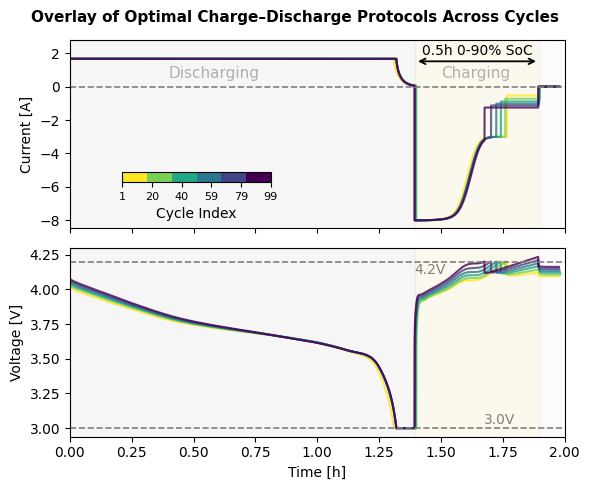

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def plot_cycle_overlays(
    simulation_slices,
    save_path=None,
    cmap_name='viridis_r',
    fig_size=(6,6),
    line_alpha=0.8,
    line_width=1.5,
    num_cycles=None,      
    max_hours=None        
):
    """
    Overlay selected cycles on 2 subplots:
      - Current vs Time (relative to cycle start)
      - Voltage vs Time
    """

    def unpack_cycle(item):
        # Support (t,I,V) / (t,I,V,soc) / (t,I,V,soc,T) / dict
        if isinstance(item, dict):
            t = item.get('t'); I = item.get('I'); V = item.get('V')
        else:
            t, I, V = item[0], item[1], item[2]
        return t, I, V

    n = len(simulation_slices)
    if n < 2:
        raise ValueError("At least two slices are required for overlay")

    # Select indices (skip index 0)
    all_indices = np.arange(1, n)
    if num_cycles is None or num_cycles >= len(all_indices):
        selected = all_indices
    else:
        selected = np.linspace(1, n-1, num_cycles, dtype=int)

    # Colors: only construct for selected
    base_cmap = plt.get_cmap(cmap_name)
    sel_colors = [base_cmap(x) for x in np.linspace(0, 1, len(selected))]
    cmap_sel = ListedColormap(sel_colors)

    # Subplots
    fig, (ax_cur, ax_vol) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=fig_size)
    fig.suptitle('Overlay of Optimal Charge–Discharge Protocols Across Cycles',
                 fontsize=11, fontweight='bold', ha='center', y=0.97)

    # Plot
    for k, i in enumerate(selected):
        t, I, V = unpack_cycle(simulation_slices[i])

        # Time relative to cycle start
        t_rel_h = (t - t[0]) / 3600.0
        if max_hours is not None:
            mask = t_rel_h <= max_hours
            if not np.any(mask):
                continue
            t_rel_h = t_rel_h[mask]; I = I[mask]; V = V[mask]

        color = cmap_sel(k)
        ax_cur.plot(t_rel_h, I, color=color, alpha=line_alpha, linewidth=line_width)
        ax_vol.plot(t_rel_h, V, color=color, alpha=line_alpha, linewidth=line_width)

    # Reference lines and labels
    ax_cur.axhline(0, linestyle='--', color='gray', linewidth=1.2)
    ax_vol.axhline(4.2, linestyle='--', color='gray', linewidth=1.2)
    ax_vol.axhline(3.0, linestyle='--', color='gray', linewidth=1.2)
    ax_cur.set_ylabel('Current [A]')
    ax_vol.set_ylabel('Voltage [V]')
    ax_vol.set_xlabel('Time [h]')

    # Text annotations (not dependent on t_h variable)
    ax_cur.text(0.75, 0.8, 'Charging', transform=ax_cur.transAxes, fontsize=11, color='gray', alpha=0.6)
    ax_cur.text(0.20, 0.8, 'Discharging', transform=ax_cur.transAxes, fontsize=11, color='gray', alpha=0.6)
    # Voltage threshold labels in voltage plot (using axes coordinates)
    ax_vol.text(0.76, 0.92, '4.2V', transform=ax_vol.transAxes, va='top', ha='right', fontsize=10, color='gray')
    ax_vol.text(0.9, 0.05, '3.0V', transform=ax_vol.transAxes, va='bottom', ha='right', fontsize=10, color='gray')

    # —— Shading: use "median cycle of selected", with relative time —— #
    if len(selected) > 0:
        mid_sel_idx = selected[len(selected)//2]
        t_mid, I_mid, _V_mid = unpack_cycle(simulation_slices[mid_sel_idx])
        t_mid_rel_h = (t_mid - t_mid[0]) / 3600.0
        if max_hours is not None:
            mask_mid = t_mid_rel_h <= max_hours
            t_mid_rel_h = t_mid_rel_h[mask_mid]
            I_mid = I_mid[mask_mid]

        def find_regions(cond):
            regs, start = [], None
            for idx, val in enumerate(cond):
                if val and start is None:
                    start = idx
                elif not val and start is not None:
                    regs.append((start, idx-1)); start = None
            if start is not None:
                regs.append((start, len(cond)-1))
            return regs

        ch_regs = find_regions(I_mid < -0.01)   # Charging (negative)
        dc_regs = find_regions(I_mid > +0.01)   # Discharging (positive)
        rs_regs = find_regions(np.isclose(I_mid, 0.0, atol=1e-3))

        for ax in (ax_cur, ax_vol):
            for s, e in dc_regs:
                ax.axvspan(t_mid_rel_h[s], t_mid_rel_h[e], color='lightgray', alpha=0.20)
            for s, e in ch_regs:
                ax.axvspan(t_mid_rel_h[s], t_mid_rel_h[e], color='#eddca5', alpha=0.20)
            for s, e in rs_regs:
                ax.axvspan(t_mid_rel_h[s], t_mid_rel_h[e], color='#f2f2f2', alpha=0.30)

        # Draw one example arrow in current plot only (if there's a charging segment)
        if ch_regs:
            s, e = ch_regs[0]
            t0, t1 = t_mid_rel_h[s], t_mid_rel_h[e]
            y_min, y_max = ax_cur.get_ylim()
            margin = 0.06 * (y_max - y_min)
            y_arrow = y_max - margin
            y_text  = y_max + 0.02 * (y_max - y_min)
            ax_cur.set_ylim(y_min, y_max + margin)
            ax_cur.annotate('', xy=(t0, y_arrow), xytext=(t1, y_arrow),
                            arrowprops=dict(arrowstyle='<->', lw=1.3))
            ax_cur.text(0.5*(t0 + t1), y_text-0.65, '0.5h 0-90% SoC', ha='center', va='bottom', fontsize=10)

    # —— colorbar: only show selected cycle indices —— #
    # Place horizontal colorbar in lower left of first subplot
    cax = inset_axes(ax_cur, width="30%", height="5%", loc='lower left',
                     bbox_to_anchor=(0.05, 0.1, 1, 1),
                     bbox_transform=ax_cur.transAxes, borderpad=2)
    sm = cm.ScalarMappable(cmap=cmap_sel)
    sm.set_array([])
    cbar = fig.colorbar(sm, cax=cax, orientation='horizontal')
    cbar.set_label('Cycle Index', fontsize=10)
    cbar.set_ticks(np.linspace(0, 1, len(selected)) if len(selected)>1 else [0.5])
    # Map ticks to actual index labels
    if len(selected) > 1:
        tick_labels = [str(int(x)) for x in np.linspace(selected[0], selected[-1], len(selected), dtype=int)]
    else:
        tick_labels = [str(int(selected[0]))] if len(selected)==1 else []
    cbar.ax.tick_params(labelsize=8)
    if tick_labels:
        cbar.set_ticklabels(tick_labels)

    # x-axis range: if max_hours is set, lock it
    if max_hours is not None:
        ax_vol.set_xlim(0.0, max_hours)

    fig.tight_layout(rect=[0, 0, 1, 1])

    if save_path:
        plt.savefig(save_path, dpi=300)
    plt.show()
    plt.close(fig)


plot_cycle_overlays(
    simulation_slices=data['Best']['simulation_data'],
    save_path="best_case_cycle_overlays.png",
    cmap_name='viridis_r',
    fig_size=(6,5),
    line_alpha=0.8,
    line_width=1.5,
    num_cycles=6,
    max_hours=2.0
)
